# Hierarchical Bayesian modelling of gene expression time series across irregularly sampled replicates and clusters

This notebook accompanies the paper

**Hierarchical Bayesian modelling of gene expression time series
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_  
<http://www.biomedcentral.com/1471-2105/14/252>

The code in this notebook uses the **development** version of GPy <https://github.com/SheffieldML/GPy‎>. 

You can download this notebook at <http://staffwww.dcs.sheffield.ac.uk/people/J.Hensman/notebooks/Hierarchical.ipynb>


In [1]:
#config
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
import numpy as np
import GPy

## Simple Hierarchical sampling

First we'll illustrate samples from the model by constructing GPy kernels and drawing random samples. We'll create a grid of time-points X on which to visualize the samples, and two kernels (covariance functions), which will form the upper and lower part of the hierarchy.

In [2]:
T = np.linspace(0, 10, 400).reshape(400,1)

#construce kernel (covariance function) objects
kern_upper = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=3.0)
kern_lower = GPy.kern.Matern32(input_dim=1, variance=0.1, lengthscale=5.0)

#compute the covariance matrices
K_upper = kern_upper.K(T)
K_lower = kern_lower.K(T)

Now we'll draw the functions representing the underlying function describing the $n^\textrm{th}$  gene $g_n(t)$, and the replications of realisations $f_{nr}(t)$. The key concept is that the draw $g_n(t)$ becomes the mean of the replicate-functions $f_{nr}(t)$.

 /home/maxz/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


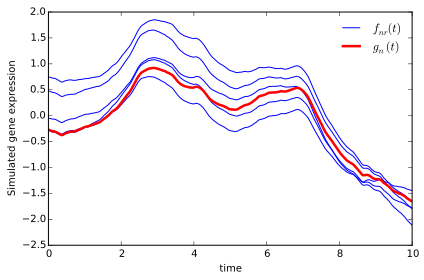

In [3]:
g = np.random.multivariate_normal(np.zeros(400), K_upper)
for r in range(5):
    f = np.random.multivariate_normal(g, K_lower)
    plt.plot(T, f, 'b', linewidth=1, label='$f_{nr}(t)$' if r==0 else None)
plt.plot(T, g, 'r', linewidth=2.5, label='$g_n(t)$')
plt.legend()
plt.xlabel('time')
plt.ylabel('Simulated gene expression')

## Hierarchical covariance functions

Since the functions $g_n(t)$ and $f_{nr}(t)$ are related linearly, they are _jointly distributed_ as a Gaussian process, which has two inputs. The first input is time, and the second indexes which function we are interested in. We'll use 0...R to represent $f_{n1}(t)\ldots f_{nR}(t)$.

GPy can construct these covariances from their underlying covariances using the hierarchical object.

In [5]:
#construct a hierarchical GPy kernel. 
kern_upper = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=2.0, active_dims=[0], name='upper')
kern_lower = GPy.kern.Matern32(input_dim=1, variance=0.1, lengthscale=4.0, active_dims=[0], name='lower')
k_hierarchy = GPy.kern.Hierarchical(kernels=[kern_upper, kern_lower])

#construct a 'grid' on which to examine samples
#the first column contains time (T), thrice. the second columns contains
#zeros, ones and twos to represent three replications. 
X = np.r_[np.c_[T, np.zeros_like(T)], np.c_[T, np.ones_like(T)], np.c_[T, np.ones_like(T)*2]]

#print to show the parameters of the hierarchical kernel are as those of both separate kernels
k_hierarchy


hierarchy.,Value,Constraint,Prior,Tied to
upper.variance,1.0,+ve,,
upper.lengthscale,2.0,+ve,,
lower.variance,0.1,+ve,,
lower.lengthscale,4.0,+ve,,


Because of the way we have structured the matrix X to contain blocks of time, the covariance contains this block structure. The diagonal (strong) block contain the covaraince of points on the _same_ replicate, and the off-diagonal blocks contain covariance between points of different replicates. 


<matplotlib.colorbar.Colorbar instance at 0x64335a8>

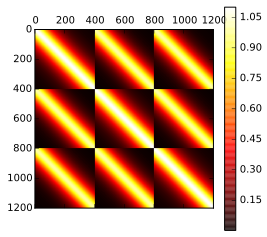

In [6]:
plt.matshow(k_hierarchy.K(X), cmap=plt.cm.hot); plt.colorbar()

It's now possible to draw samples from the replicates simultaneously.  Notice that here we don't have a draw for the underlying function $g_n(t)$: this has been marginalised out. We can perform inferences for $g$, but since it's an unobserved latent process, it's not required for computation. 

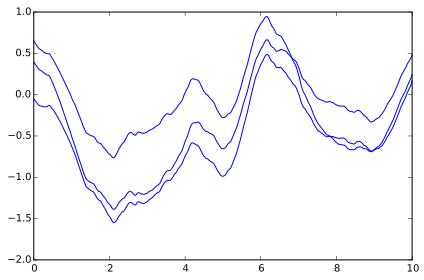

In [7]:
sample = np.random.multivariate_normal(np.zeros(X.shape[0]), k_hierarchy.K(X))
for r in range(3):
    index = X[:,1]==r
    plt.plot(X[index,0], sample[index], 'b', linewidth=1)
                                  

## Drosophila data

Here we model the data in 

**Gene expression divergence recapitulates the developmental hourglass model**  
_Alex T. Kalinka,	Karolina M. Varga,	Dave T. Gerrard,	 Stephan Preibisch,	 David L. Corcoran,	 Julia Jarrells,	Uwe Ohler,	Casey M. Bergman and Pavel Tomancak	_  
Nature 468, 811–814 (09 December 2010)

The data are available at http://publications.mpi-cbg.de/publications-sites/4240/Supplemental_Information_Summary.html#Raw_data. These are a time series experiment across several species, with several replicates. We have downloaded these data, and filtered for only the Melanogaster rows. This results in 57 measurements of 3590 genes, spread (unevenly) across 8 replicates. 


In [8]:
import urllib
urllib.urlretrieve('http://staffwww.dcs.sheffield.ac.uk/people/J.Hensman/data/kalinka09_mel.csv', 'kalinka_data.csv')
urllib.urlretrieve('http://staffwww.dcs.sheffield.ac.uk/people/J.Hensman/data/kalinka09_mel_pdata.csv', 'kalinka_pdata.csv')
expression = np.loadtxt('kalinka_data.csv', delimiter=',', usecols=range(1, 57))
gene_names = np.loadtxt('kalinka_data.csv', delimiter=',', usecols=[0], dtype=np.str)
replicates, times = np.loadtxt('kalinka_pdata.csv', delimiter=',').T

#normalize data row-wise
expression -= expression.mean(1)[:,np.newaxis]
expression /= expression.std(1)[:,np.newaxis]

## Inference in a single gene

Here's a simple plot of the data in a single gene. Each sup-plot represents one replicate. Note how some replicates do not contain all the time points. 

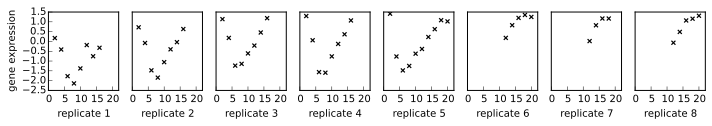

In [16]:
plt.figure(figsize=(10,1.85))
gene_index = 12 # hoppefully a typical gene
for r in range(1,9):
    plt.subplot(1,8,r)
    index = replicates==r
    plt.plot(times[index], expression[gene_index, index], 'kx', mew=1.2, ms=4)
    plt.xlabel('replicate %i'%r)
    
    if r==1:plt.ylabel('gene expression')
GPy.plotting.matplot_dep.base_plots.align_subplots(1,8, xlim=(0,22))

To construct a GP model, we need to for the matrix X as for the sampling above, with one column representing the times of observation, and the other containing the replicate index.


In [17]:
X = np.hstack((times.reshape(-1,1), replicates.reshape(-1,1)))
Y = expression[gene_index].reshape(-1,1) #must be a column vector for GPy
m = GPy.models.GPRegression(X=X, Y=Y, kernel=k_hierarchy)
m.likelihood.variance = 0.01
m.optimize('bfgs', messages=1)

 :0: FutureWarning:IPython widgets are experimental and may change in the future.


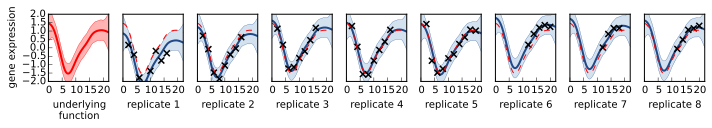

In [19]:
plt.figure(figsize=(10,1.85))
#to plot the mean function g_n(t), predict using only the 'upper' kernel
Xplot = np.linspace(0,22, 100)[:,None]
mu, var = m.predict(Xplot, kern=kern_upper)
ax = plt.subplot(1,9,1)
GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
plt.ylabel('gene expression')
plt.xlabel('underlying\nfunction')

#plot each of the functions f_{nr}(t)
for r in range(1,9):
    ax = plt.subplot(1,9,r+1)
    m.plot(fixed_inputs=[(1,r)],ax=ax, which_data_rows=X[:,1]==r)
    plt.xlabel('replicate %i'%r)
    plt.plot(Xplot, mu, 'r--', linewidth=1)
    
GPy.plotting.matplot_dep.base_plots.align_subplots(1,9, xlim=(0,22), ylim=(-2,2))

In the above, we've plotted the hierarchical GP posterior, including our posterior over the underlying function. For each replicate, the shaded area represents a 95 confidence interval in another point _in that replicate_. We also show the mean of the underlying function as red dashes: it's clear that there is a strong batch effect which our model copes with well. Note that this would be hard to normalize-out because of the disorganised replicate structure. 

To demonstrate what we've gained from the hierarchical model, let's compare with two simpler methods. First, fitting a GP to all the data without considering the replicate structure, and second, averaging at each time point before fitting a GP.

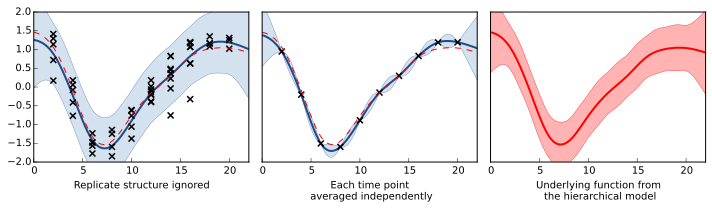

In [22]:
plt.figure(figsize=(10,3))
#lump all the data together into a single GP
m_lump  = GPy.models.GPRegression(X[:,0:1], Y, kernel=GPy.kern.Matern32(1))
m_lump.optimize()
m_lump.plot(ax=plt.subplot(1,3,1))
plt.plot(Xplot, mu, 'r--', linewidth=1)
plt.xlabel('Replicate structure ignored')

#average each time point
X_unique = np.unique(X[:,0])
Y_u = []
for x in X_unique:
    Y_u.append(Y[X[:,0]==x].mean())
Y_u = np.array(Y_u).reshape(-1,1)
m_ave = GPy.models.GPRegression(X_unique[:,None], Y_u, kernel=GPy.kern.Matern32(1))
m_ave.optimize()
m_ave.plot(ax=plt.subplot(1,3,2))
plt.plot(Xplot, mu, 'r--', linewidth=1)
plt.xlabel('Each time point\n averaged independently')

#plot the hierarchical result
ax = plt.subplot(1,3,3)
GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
GPy.plotting.matplot_dep.base_plots.align_subplots(1,3, xlim=(0,22), ylim=(-2,2))
plt.xlabel('Underlying function from\n the hierarchical model')

## Deeper Hierarchies

It's straightforward to add another layer of the hierarchy to ther model. Here, we'll take some genes that have been clustered together and build a Hierarchical GP with three layers. At the top, is an underlying function which governs the behaviour of all the genes. Beneath that is another GP which models gene-specific deviations from the cluster, and below that a GP to model replicate variation as above. 

We'll construct a design matrix X which contains three columns. The first is time, the next indexes the gene and the third indexes the replicate. We'll arrange the observed gene expression values into a single column vector Y similarly. 

In [23]:
k_cluster = GPy.kern.Matern32(input_dim=1, active_dims=[0], name='cluster', variance=1.5, lengthscale=2.5)
k_gene = GPy.kern.Matern32(input_dim=1, active_dims=[0], name='gene', variance=0.1, lengthscale=2.5)
k_replicate = GPy.kern.Matern32(input_dim=1, active_dims=[0], name='replicate', variance=0.1, lengthscale=2.5)

k_hierarchy = GPy.kern.Hierarchical([k_cluster, k_gene, k_replicate])

In [24]:
clustered_gene_names = np.array(['ac', 'bib', 'yellow-e3', 'Tom', 'CG13333', 'tld'], dtype=np.str)
index = [i for i,gn in enumerate(gene_names) if gn in clustered_gene_names]
Y_cluster = expression[index]

X = []
for i in range(len(index)):
    X.append(np.hstack((times.reshape(-1,1), np.ones((times.size,1))*i, replicates.reshape(-1,1) + i*8)))
X = np.vstack(X)
Y = np.vstack([y.reshape(-1,1) for y in Y_cluster])

In [26]:
m = GPy.models.GPRegression(X, Y, kernel=k_hierarchy)
m.optimize(messages=1)

That's it for inference. All that remains is to plot the GP predictions. Here we'll follow the convention above of plotting the replicates of a gene in rows, with the first column showing the underlying function for that gene. 

In the bottom row we'll plot a prediction for a new 'unseen' gene. Note that the errorbars are larger since they comprise the gene-variance, replicate-varaince and the noise. The very bottom-left plot shows the posterior of the top-level underlying function (green). 

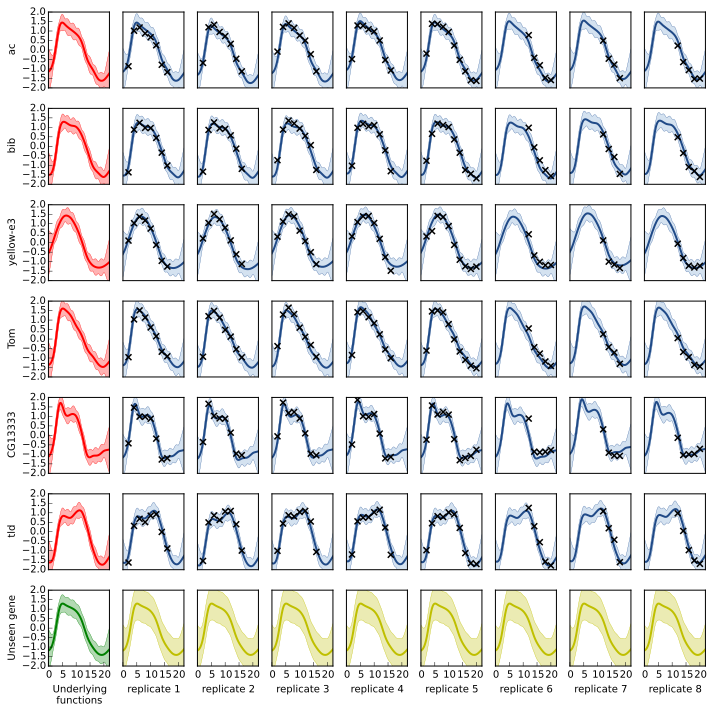

In [28]:
f, ax_array = plt.subplots(len(clustered_gene_names)+1, 9, figsize=(10,10))
#create the kernel for making predictions of the gene-specific functions (turn off replicate variance)
k_pred = k_hierarchy.copy()
k_pred.replicate.variance=0
for g, gn in enumerate(clustered_gene_names):
    Xpred = np.hstack((Xplot, Xplot*0+g, Xplot*0))
    mu, var = m.predict(Xpred, kern=k_pred)
    ax = ax_array[g,0]
    GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='r', fillcol='r')
    ax.set_ylabel(gn)
    for r in range(8):
        ax = ax_array[g,r+1]
        m.plot(fixed_inputs=[(1,g),(2,r+g*8)], ax=ax, which_data_rows=np.logical_and(X[:,1]==g, X[:,2]==((r+1)+g*8)))

        
#create the kernel for making predictions of the overall function (turn off the replicate- and gene-variance)
k_pred = k_hierarchy.copy()
k_pred.replicate.variance = 0.0
k_pred.gene.variance = 0.0
mu, var = m.predict(Xpred, kern=k_pred)
ax = ax_array[-1,0]
GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax, edgecol='g', fillcol='g')

#predict the gene expression for a completely new gene (give it index 100)
Xpred = np.hstack((Xplot, Xplot*0+100, Xplot*0 + 100))
mu, var = m.predict(Xpred)
[GPy.plotting.matplot_dep.base_plots.gpplot(Xplot, mu, mu - 2*np.sqrt(var), mu + 2*np.sqrt(var), ax=ax_array[-1,i], edgecol='y', fillcol='y') for i in range(1,9)]

#set some labels
ax_array[-1,0].set_ylabel('Unseen gene')
ax_array[-1,0].set_xlabel('Underlying\nfunctions')
[ax_array[-1,i].set_xlabel('replicate %i'%(i)) for i in range(1,9)]
GPy.plotting.matplot_dep.base_plots.align_subplot_array(ax_array, xlim=(0,22), ylim=(-2,2))
plt.tight_layout()